In [1]:
dataset <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"
match_dist <- 15000
new_dataset <- "FVG"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
Sys.setlocale("LC_ALL", "UTF-8")
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


[1] "C/UTF-8/C/C/C/C"

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    anti_join(tibble(sensor_key = c(3984L, 2938L, 2939L), dataset = c("SCIA", "ISAC", "ISAC")), copy = TRUE, by = c("dataset", "sensor_key")) |> # TRIESTE provides terrible data + AT stations
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 10000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Veneto"), !str_starts(series_id, "AT_"))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    filter(!(dataset == "ARPAFVG" & sensor_key %in% c(31L))) # Monfalcone provides terrible data
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA", "ISAC"), "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", "FVG", "raw_analysis.xlsx"))


In [69]:
source("notebooks/ds_regionali/FVG/procedures/match_taggers.R")
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", "FVG", "tagged_analysis.xlsx"), starts_with("tag_"))


In [70]:
metadata2 <- query_checkpoint_meta(c("ARPAFVG", "SCIA", "ISAC"), "raw", conns$data) |> collect()

network_rank_table <- tribble(
    ~dataset, ~network, ~network_rank,
    "ISAC", "ISAC", 1L, # ISAC series are always ranked first
    "ISAC", "DPC", 4L #  DPC series are always ranked last
) |>
    bind_rows(
        metadata |> filter(dataset == "SCIA") |> distinct(dataset, network) |> mutate(network_rank = 3L) #  SCIA series are ranked second to last
    ) |>
    bind_rows(
        metadata |> filter(!dataset %in% c("SCIA", "ISAC")) |> distinct(dataset, network) |> mutate(network_rank = 2L) # ARPA series are ranked second
    )

# VEDERE SE USARE: ASSEGNAZIONE RANKING PER LUNGHEZZA DELLA SERIE, IN MODO DA NON PRENDERE COME RIFERIMENTO SERIE TROPPO CORTE
length_rank_table <- tribble(
    ~from, ~to, ~length_rank,
    0L, 365L * 4L, 2L,
    365L * 4L + 1L, Inf, 1L
) # ???

# gs <- groups_table |>
#     left_join(metadata |> select(dataset, sensor_key, network, sensor_last), by = c("dataset", "sensor_key"))


In [71]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_groups <- gs$table |>
    left_join(metadata |> select(key, dataset, sensor_key, network, sensor_last), by = "key") |>
    left_join(network_rank_table, by = c("dataset", "network")) |>
    group_by(gkey, variable) |>
    arrange(network_rank, desc(sensor_last), .by_group = TRUE) |>
    mutate(rank = row_number(), skip_correction = "ISAC" %in% network, set = "FVG") |>
    ungroup() |>
    select(!c(sensor_last, network_rank, network))
# Dealing with ISAC series
# ranked_series_groups <- rank_series_groups(
#     gs$table,
#     metadata |> mutate(network_prio = if_else(network == "ISAC", 2L, 1L)),
#     c("ARPAFVG", "SCIA", "ISAC"),
#     desc(dataset), desc(sensor_last)
# )
# ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
# incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 15L, 0.5, ignore_corrections)


In [72]:
source("notebooks/merging/correzioni_manuali.R")
dynamic_merge.full(fs::path_wd("data"), fs::path_wd("test"), ranked_groups, 10, 0L)


In [73]:
open_dataset(fs::path("test/meta")) |>
    collect() |>
    left_join(metadata2 |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key")) |>
    mutate(mean_corr = k0 + 2*k1/pi) |>
    filter(abs(mean_corr) > 0.5) |>
    arrange(desc(abs(mean_corr)))


key,gkey,variable,dataset,sensor_key,rank,skip_correction,set,k0,k1,k2,k3,merged,offset,name,mean_corr
<int>,<int>,<int>,<chr>,<int>,<int>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<chr>,<dbl>
158,24,-1,ISAC,2096,3,FALSE,FVG,-1.8290016,0.0000000,0.00000000,0.0000000000,TRUE,0,MONFALCONE,-1.8290016
441,40,-1,SCIA,3912,3,FALSE,FVG,-1.4975227,0.3030023,0.09578833,0.0150930101,TRUE,0,TARVISIO,-1.3046255
180,31,-1,ISAC,2597,3,FALSE,FVG,-1.7007088,0.6767592,-0.07610313,-0.1099584903,TRUE,0,PIANCAVALLO,-1.2698705
393,31,-1,SCIA,2784,2,FALSE,FVG,-1.5209105,0.4307102,-0.07449927,-0.1321087507,TRUE,0,PIANCAVALLO PISTA DI FONDO,-1.2467119
374,25,1,SCIA,2405,3,FALSE,FVG,0.8500246,0.6099193,0.11587039,-0.0010598148,TRUE,0,Monte Lussari,1.2383113
30,25,1,ARPAFVG,32,2,FALSE,FVG,0.6230013,0.4183563,0.04900215,-0.0596347273,TRUE,0,Monte Lussari (fino al 08/01/2018),0.8893352
209,139,1,ISAC,2973,2,FALSE,FVG,-0.9795240,0.2400740,-0.54233851,-0.1595549842,TRUE,0,RIFUGIO_TAMAI_ZONCOLAN,-0.8266881
171,29,1,ISAC,2450,2,FALSE,FVG,0.8133971,0.0000000,0.00000000,0.0000000000,TRUE,0,PALA_D_ALTEI,0.8133971
97,10,1,ISAC,991,3,FALSE,FVG,0.7899038,0.0000000,0.00000000,0.0000000000,TRUE,0,CIVIDALE_S_M,0.7899038


In [68]:
i <- open_dataset(fs::path("test/meta")) |>
    collect() |>
    left_join(metadata2 |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key")) |>
    mutate(mean_corr = k0 + 2*k1/pi) |>
    filter(gkey == 41L)
i

key,gkey,variable,dataset,sensor_key,rank,skip_correction,set,k0,k1,k2,k3,merged,offset,name,mean_corr
<int>,<int>,<int>,<chr>,<int>,<int>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<chr>,<dbl>
46,41,-1,ARPAFVG,49,1,TRUE,FVG,0.0000000,0.00000000,0.00000000,0.00000000,TRUE,0,Sgonico-Zgonik,0.0000000
437,41,-1,SCIA,3838,2,FALSE,FVG,-0.5050360,0.04170909,-0.02792311,-0.01000265,TRUE,0,Sgonico,-0.4784832
224,41,-1,ISAC,3355,3,FALSE,FVG,-0.5739336,0.00000000,0.00000000,0.00000000,TRUE,0,SGONICO,-0.5739336
46,41,1,ARPAFVG,49,1,TRUE,FVG,0.0000000,0.00000000,0.00000000,0.00000000,TRUE,0,Sgonico-Zgonik,0.0000000
437,41,1,SCIA,3838,2,FALSE,FVG,0.4150791,0.50888410,0.02868203,0.05491216,TRUE,0,Sgonico,0.7390447
224,41,1,ISAC,3355,3,FALSE,FVG,0.7490385,0.00000000,0.00000000,0.00000000,TRUE,0,SGONICO,0.7490385


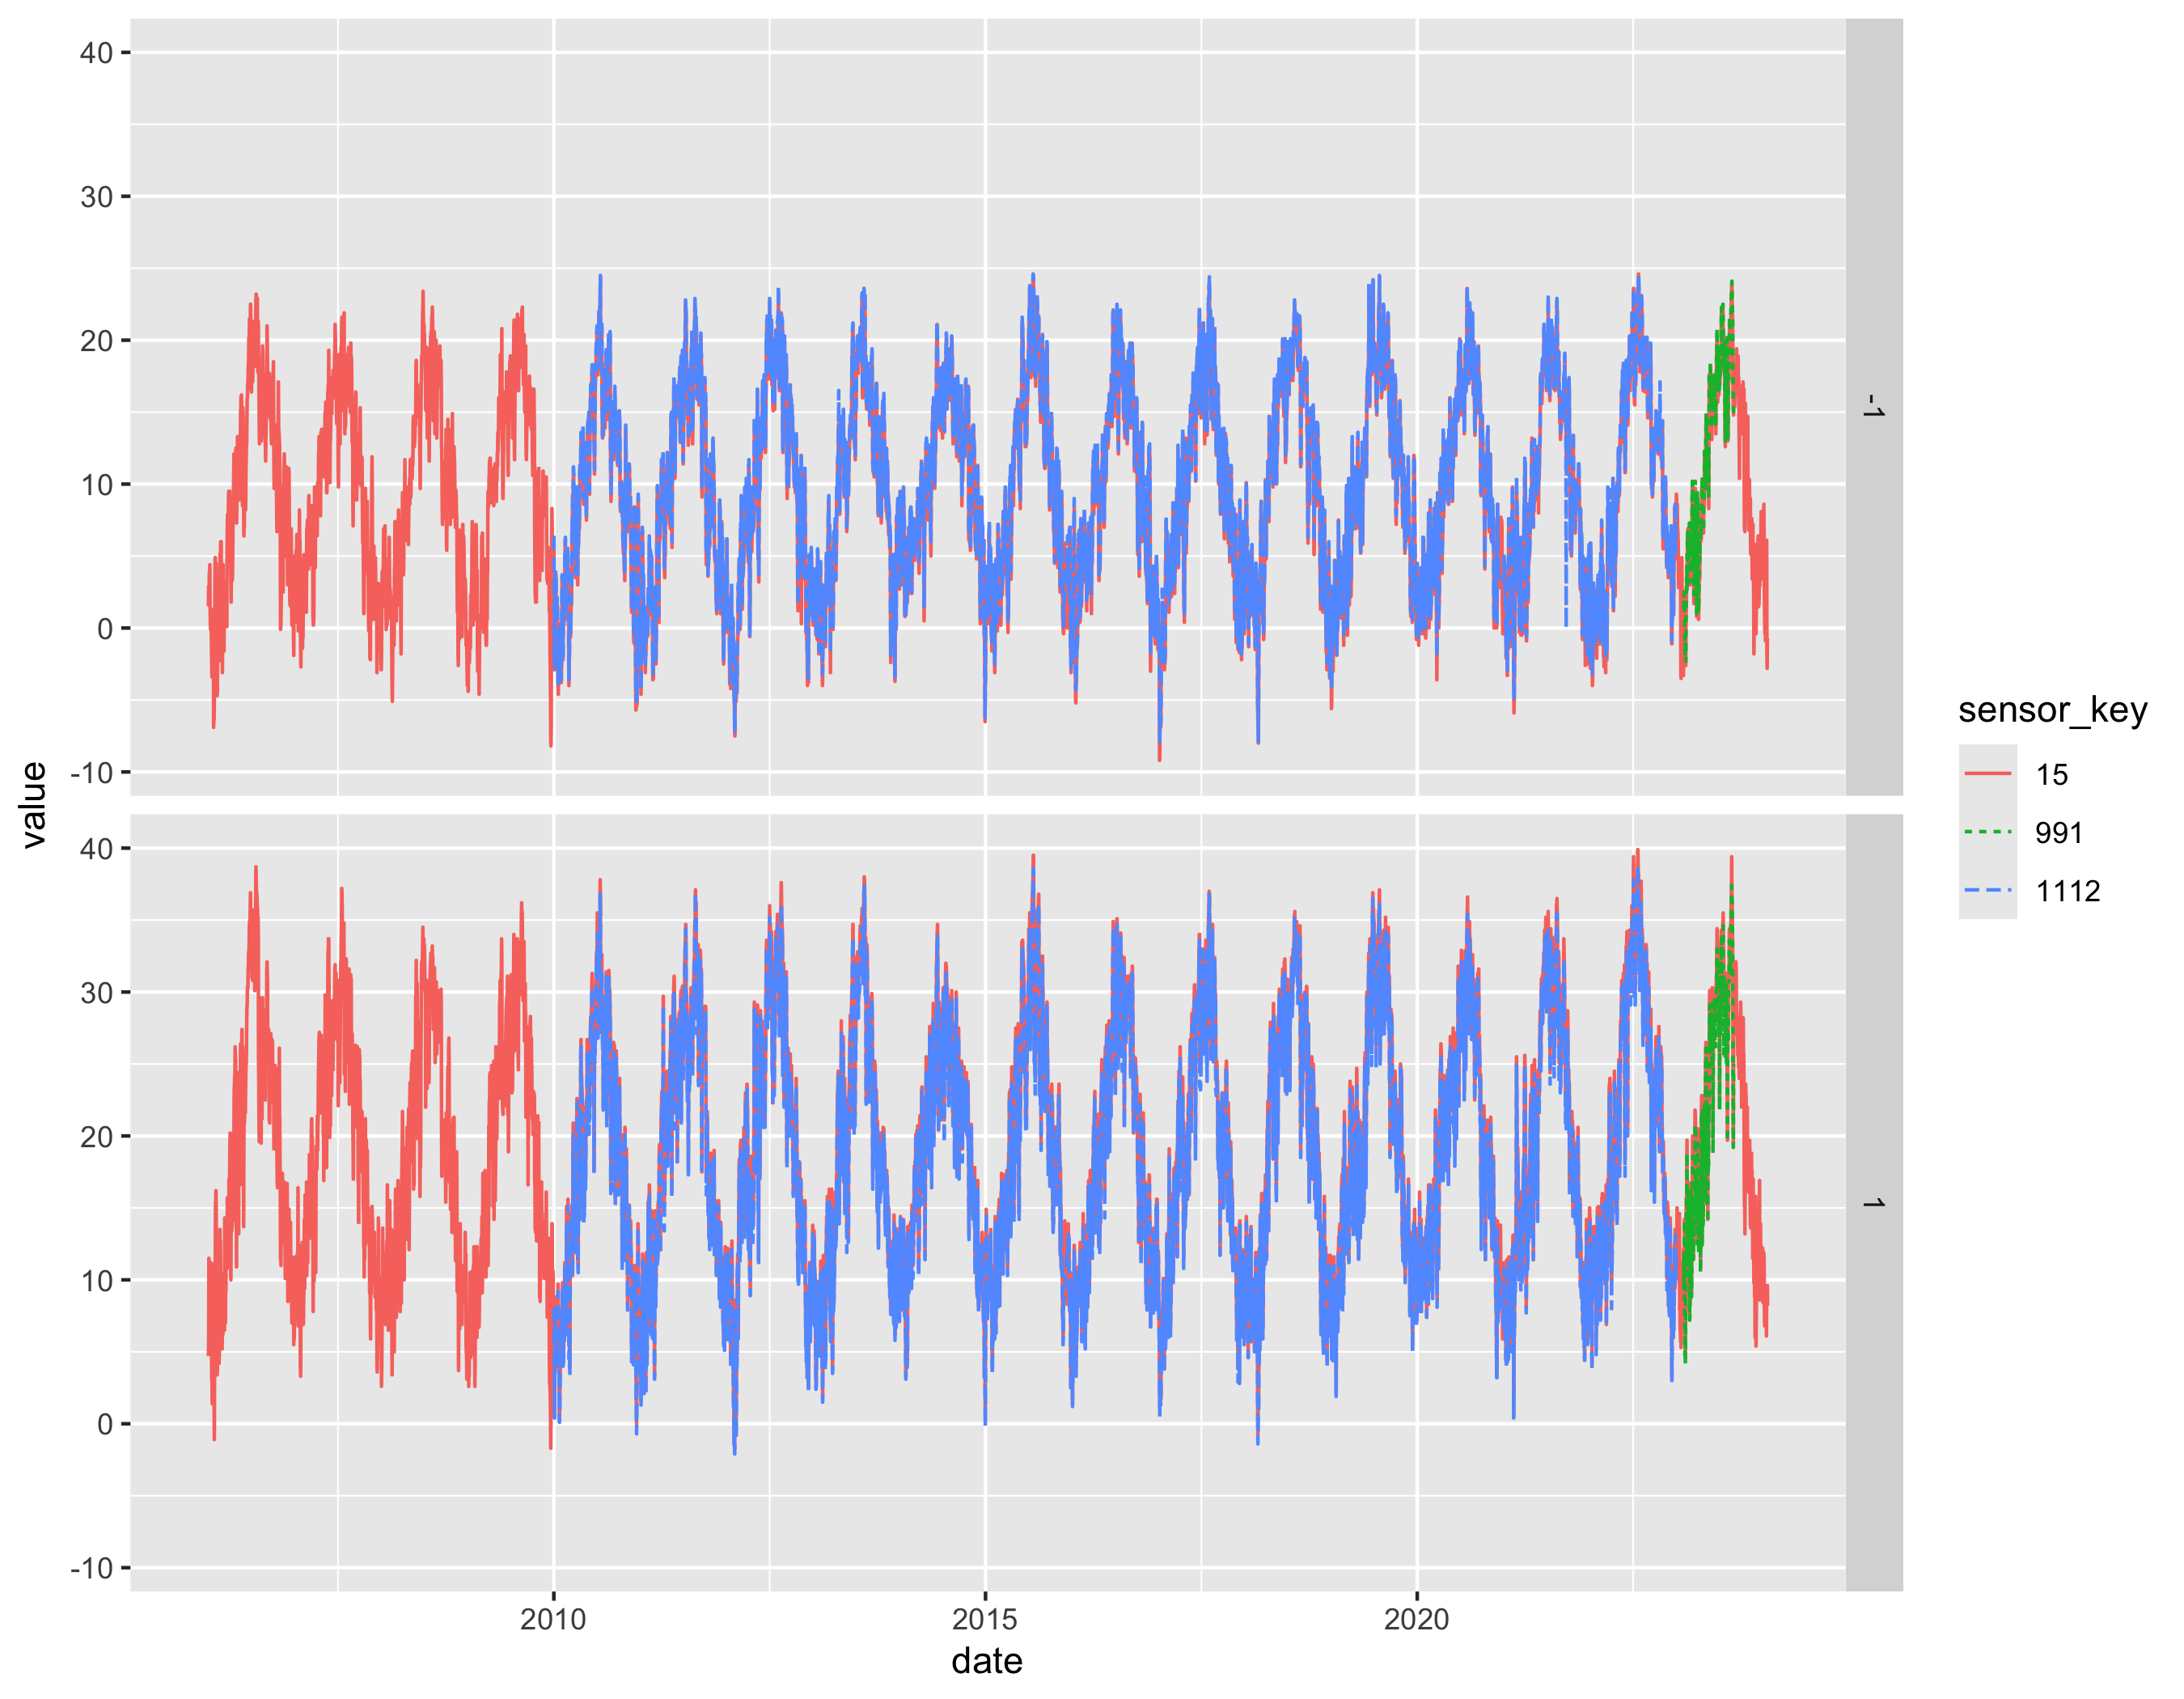

In [67]:
# metadata |> filter(name |> str_to_lower() |> str_detect("chiusaforte")) |> select(dataset, sensor_key) |>
plot_stations(
    i |> select(dataset, sensor_key) ,
    data |> filter(year(date) > 2005L),
    same_period = F
)

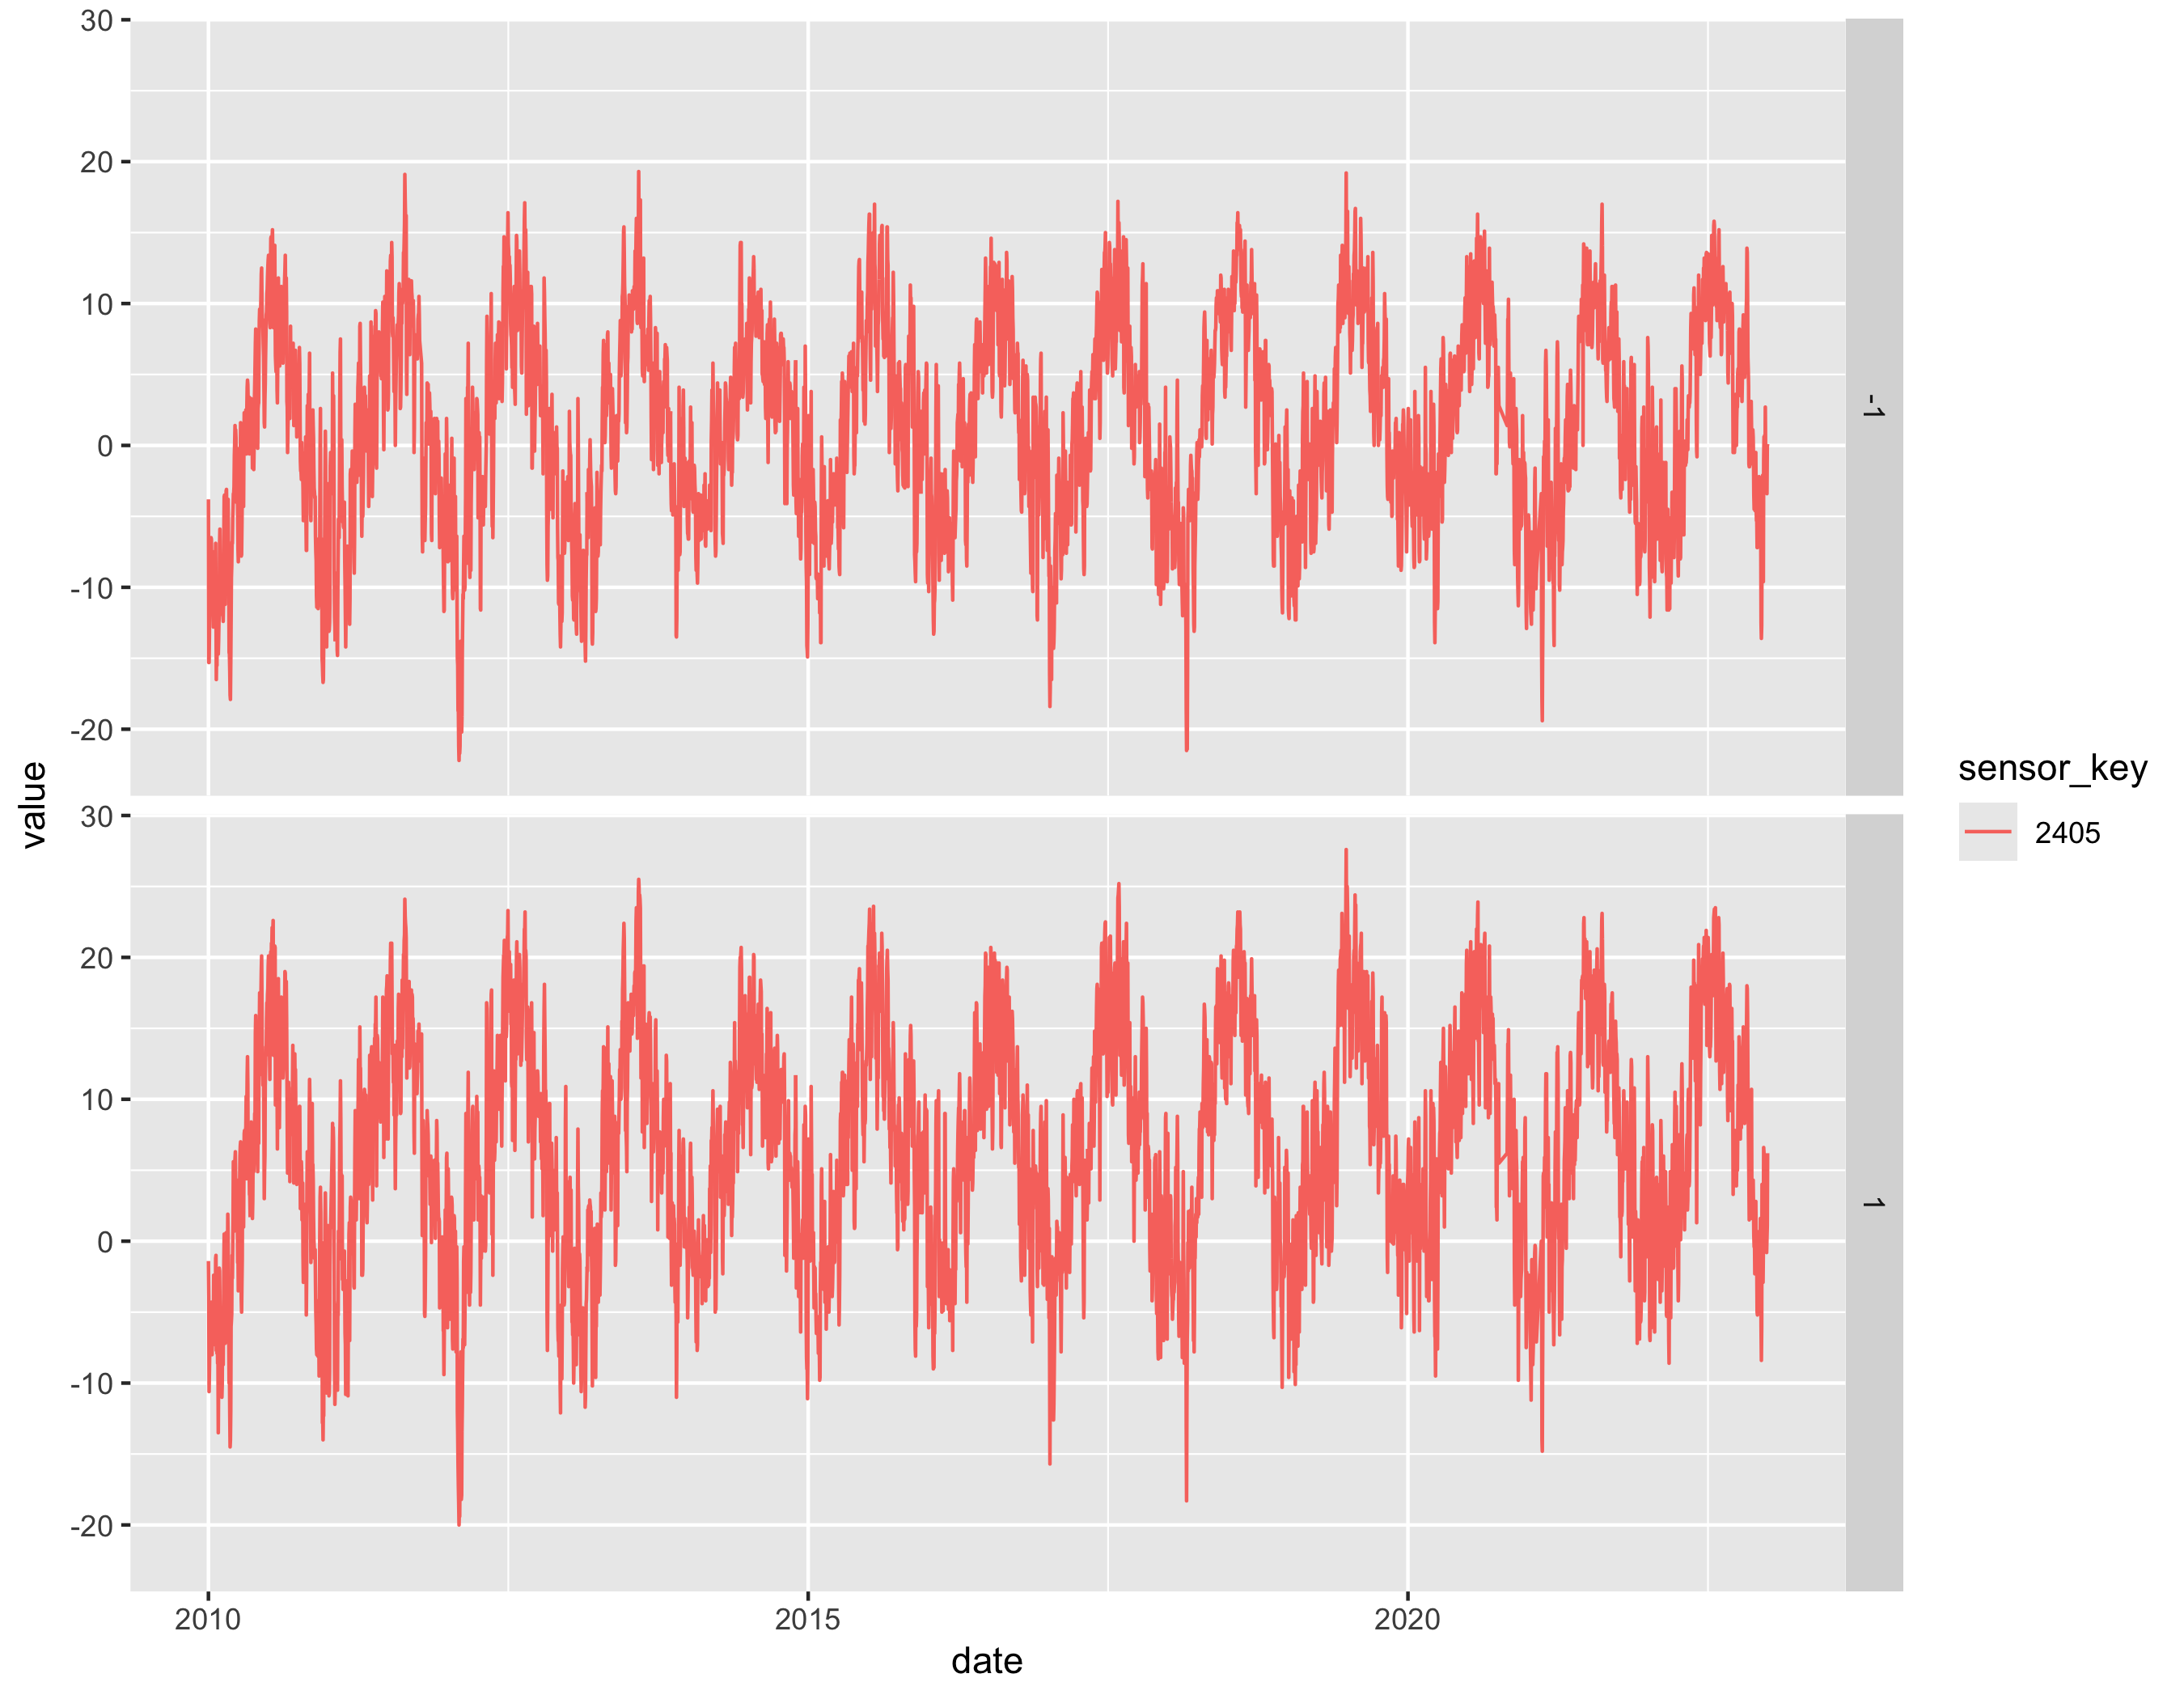

In [60]:
plot_stations(
    tibble(sensor_key = 2405L, dataset = "SCIA"),
    data |> filter(year(date) > 2000L),
    same_period = F
)